In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import os
import scipy.io as sio
font_t = {'weight' : 'bold'}
RESO = 4096  # The pictures in the dataset is with solution 8192*4096

In [2]:
dir_ori = '/Users/zhangjiayu/Desktop/selected_data/original_images/'
dir_com = '/Users/zhangjiayu/Desktop/selected_data/compressed_images/'
heatmaps_jiayu = np.load('/Users/zhangjiayu/Desktop/jiayu_heatmaps.npy', encoding="latin1").item()
heatmaps_sitzmann = np.load('/Users/zhangjiayu/Desktop/sal_heatmap.npy', encoding="latin1").item()

In [3]:
# Convert RGB to YUV
# Reference: https://gist.github.com/Quasimondo/c3590226c924a06b276d606f4f189639
def rgb2yuv(img):   
    m = np.array([[ 0.29900, -0.16874,  0.50000],
                 [0.58700, -0.33126, -0.41869],
                 [ 0.11400, 0.50000, -0.08131]])
    yuv = np.dot(img, m)
    yuv[:, :, 1:] += 128.0
    return yuv[:, :, 0]

#Rename stimuli
def rn_st(s):
    d = {'0002':'Seashore', '0004':'Swimming Pool', '0006':'Chess', '0007':'Clock Tower', '0012':'Bedroom', 
         '0013':'Snow', '0015':'Shark', '0016':'Office', '0018':'Railway', '0019':'Cabin'}
    return d[s]

In [7]:
# Compute PSNR values
def psnr(img_o, img_r, RESO):
    mse = np.sum(np.square(img_o - img_r)) * (1.0/ (RESO * 2.0 * RESO))
    if abs(mse) <= 0.00001:
        return math.inf
    PIXEL_MAXIMUM = 255.0
    return 10.0 * math.log10(PIXEL_MAXIMUM **2 / mse)

# Compute WS-PSNR values
def ws_psnr(img_o, img_r, RESO):
    wmse = 0
    size = img_o.shape
    dim1, dim2 = size[0], size[1]
    temp = np.ones((dim1, dim2))
    temp = temp * (np.arange(dim1).reshape(-1,1))
    sf = np.cos((temp - RESO / 2.0 + 0.5) * (math.pi / RESO))
    weight = sf / np.sum(sf)
    wmse = np.sum(weight * np.square(img_o - img_r))        
    if abs(wmse) <= 0.00001: 
        return math.inf
    PIXEL_MAXIMUM = 255.0
    return 10.0 * math.log10(PIXEL_MAXIMUM**2 / wmse)

# Compute VA-PSNR values
def va_psnr(img_o, img_r, RESO, n, heat, a):
    wmse = 0
    size = img_o.shape
    dim1, dim2 = size[0], size[1]
    temp = np.ones((dim1, dim2))
    temp = temp * (np.arange(dim1).reshape(-1,1))
    # heatmaps = np.load('/Users/zhangjiayu/Desktop/jiayu_heatmaps.npy', encoding="latin1").item()
    # print(heatmaps.keys())
    if a == 1:
        weight = heat['sitzmann_00' + str(n)]
    else:
        weight = heat['sitzmann00' + str(n)]
        
    weight = cv2.resize(weight, dsize=(8192, 4096), interpolation=cv2.INTER_CUBIC) 
    weight = weight/np.sum(weight)
    
    #INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
    #INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood
    wmse = np.sum(weight * np.square(img_o - img_r))          
    if abs(wmse) <= 0.00001: 
        return math.inf
    PIXEL_MAXIMUM = 255.0
    return 10.0 * math.log10(PIXEL_MAXIMUM**2 / wmse)

[[37.89075837  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]
[[37.89075837  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [41.80466411  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]]
[[37.89075837  0.          0.          0.          0.         

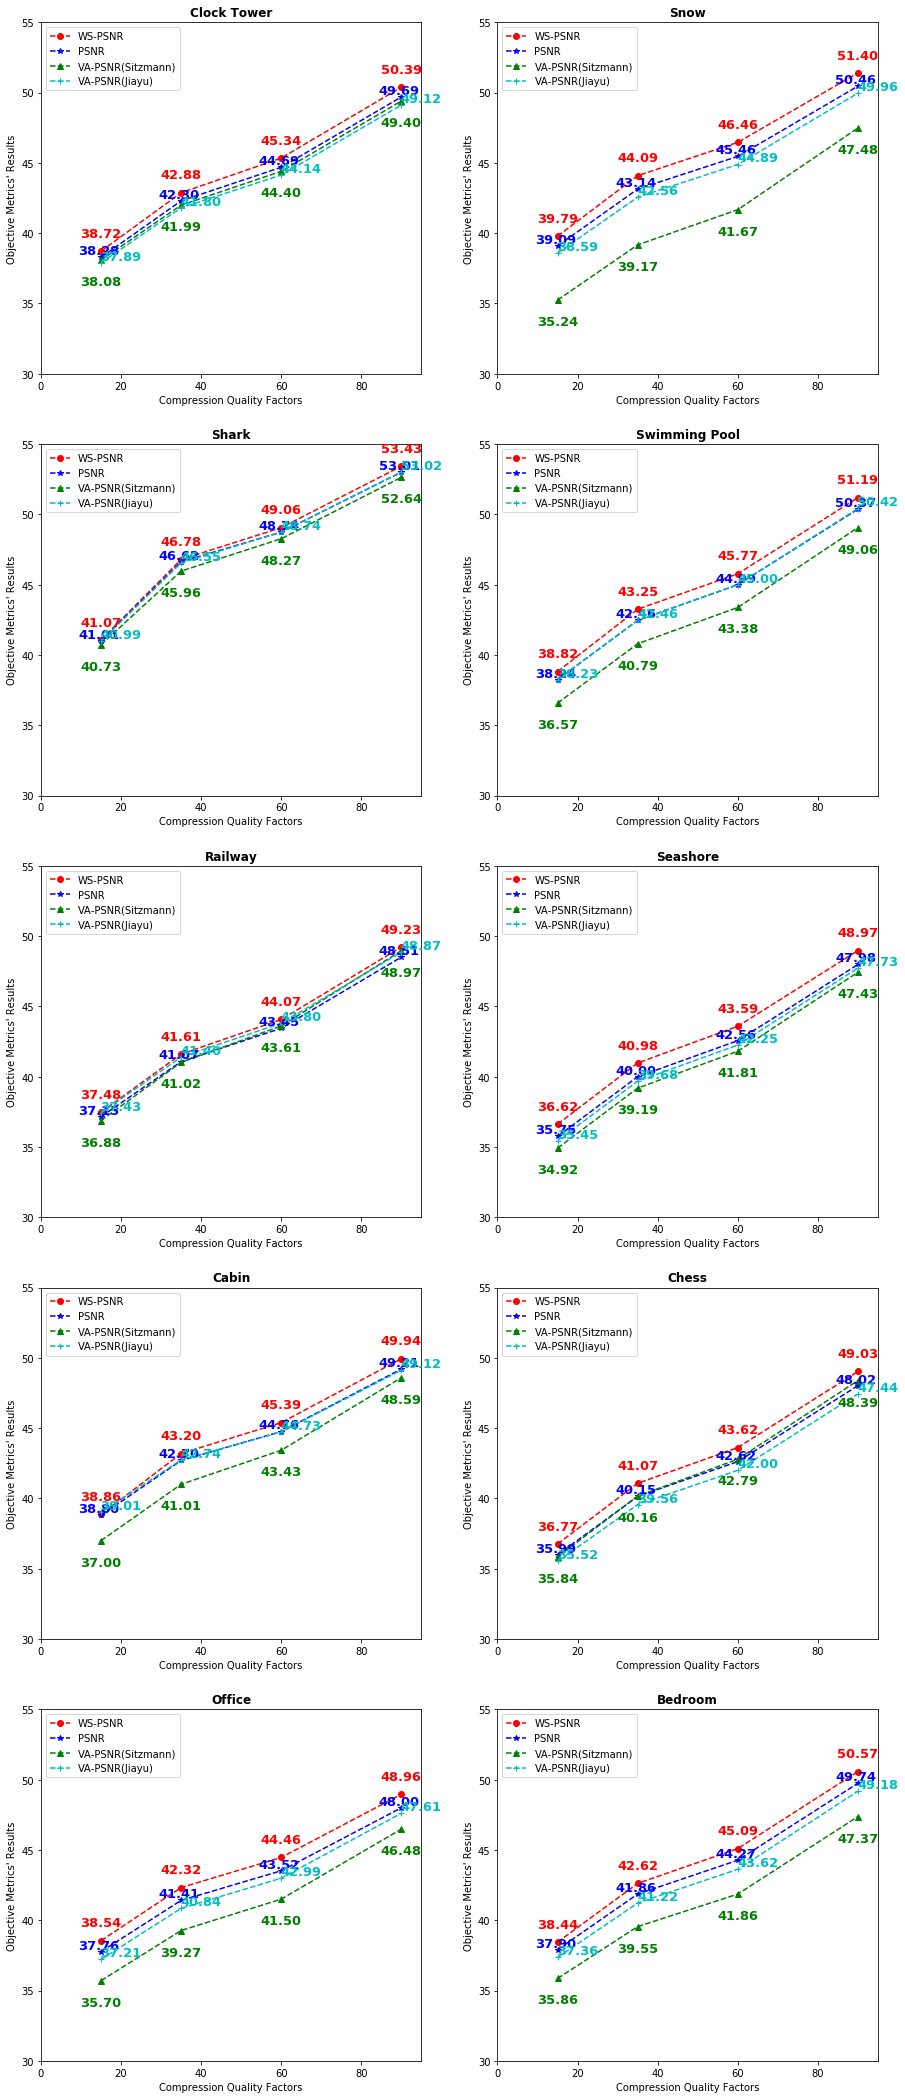

In [13]:
plt.figure(figsize = (15, 37.5))
# plt.suptitle('PSNR vaules with different compression quality factor')
x_plot = [15, 35, 60, 90]

files = os.listdir(dir_ori)
rn_img = [rn_st(s.split('_')[1]) for s in files]

#list_name = [2, 4, 6, 7, 12, 13, 15, 16, 18, 19]
#image_name = ['Seashore', 'Swimming Pool', 'Chess', 'Clock Tower', 'Bedroom', \
#              'Snow', 'Shark', 'Office', 'Railway', 'Cabin']

list_name = [7, 13, 15, 4, 18, 2, 19, 6, 16, 12]
image_name = ['Clock Tower', 'Snow', 'Shark', 'Swimming Pool', 'Railway', 'Seashore', \
              'Cabin', 'Chess', 'Office', 'Bedroom']

psnr_vals = np.zeros((4, 4, 10))  # A 3 dimentions array, 3*4*22  in 1st dimention 0-PSNR; 1-WS_PSNR; 2-VA_PSNR(S); 3-WS_PSNR(J)
#Implement PSNR, WS-PSNR, VA-PSNR for each image
for idx in range(len(list_name)):
    # Read original pictures
    # Convert from RGB to YUV and return Y channel
    #if (i==2 or i==4 or i==6 or i==7 or i==12 or i==13 or i==15 or i==16 or i==18 or i==19):
    
    i = list_name[idx]
    
    n = "%02d" % i
    ori_name = 'sitzmann_00' + str(n) + '_equirec_8192x4096_jpeg_qO.png'
    img = Image.open(dir_ori + ori_name)
    img = img.convert('RGB')
    img_ori = rgb2yuv(img)

    # Read compressed pictures and compute psnr values
    # PSNR values computation 
    # psnr_vals = np.zeros((4, 4, 10))  # A 3 dimentions array, 4*4*22  in 1st dimention 0-PSNR; 1-WS_PSNR; 2-VA_PSNR
    img_com = {"15": []}
    
    qf_table = [15, 35, 60, 90]

    for j in range(0, 4):
        qf = qf_table[j]
        
        
        img = mpimg.imread(dir_com + 'sitzmann_00' + str(n) + '_equirec_8192x4096_jpeg_q' + str(qf) + '.jpg')
        img_com[str(qf)] = rgb2yuv(img)
    
        psnr_vals[0, j, idx] = psnr(img_ori, img_com[str(qf)], RESO)
        psnr_vals[1, j, idx] = ws_psnr(img_ori, img_com[str(qf)], RESO)
        psnr_vals[2, j, idx] = va_psnr(img_ori, img_com[str(qf)], RESO, n, heatmaps_sitzmann, 1)
        psnr_vals[3, j, idx] = va_psnr(img_ori, img_com[str(qf)], RESO, n, heatmaps_jiayu, 2)
        print(psnr_vals[3, :, :])

    # Plotting
    y_psnr = psnr_vals[0, :, idx]
    y_ws_psnr = psnr_vals[1, :, idx]
    y_va_psnr_s = psnr_vals[2, :, idx]
    y_va_psnr_j = psnr_vals[3, :, idx]

    plt.subplot(5, 2, idx+1)
    plt.title(image_name[idx], **font_t)
    
    plot1 = plt.plot(x_plot, y_psnr, 'ro--', label = 'WS-PSNR')
    plot2 = plt.plot(x_plot, y_ws_psnr, 'b*--', label = 'PSNR')
    plot3 = plt.plot(x_plot, y_va_psnr_s, 'g^--', label = 'VA-PSNR(Sitzmann)')
    plot4 = plt.plot(x_plot, y_va_psnr_j, 'c+--', label = 'VA-PSNR(Jiayu)')

    for x, y in zip(x_plot, y_psnr):
        plt.text(x, y + 0.8, '%.2f'%y, ha='center', va='bottom', fontsize=13, color = 'red', weight = 'bold')
    for x, y in zip(x_plot, y_ws_psnr):
        plt.text(x - 0.5, y, '%.2f'%y, ha='center', va='bottom', fontsize=13, color = 'blue', weight = 'bold')
    for x, y in zip(x_plot, y_va_psnr_s):
        plt.text(x, y - 2.0, '%.2f'%y, ha='center', va='bottom', fontsize=13, color = 'green', weight = 'bold')
    for x, y in zip(x_plot, y_va_psnr_j):
        plt.text(x + 5, y, '%.2f'%y, ha='center', va='bottom', fontsize=13, color = 'c', weight = 'bold')
        
    plt.xlim(0.0, 95.0)
    plt.ylim(30.0, 55.0)
    plt.legend(loc = 'upper left')
    plt.xlabel('Compression Quality Factors')
    plt.ylabel('Objective Metrics\' Results')
    



plt.savefig('/Users/zhangjiayu/Desktop/jiayu_psnr.png', dpi = 600)
plt.show()

sio.savemat('/Users/zhangjiayu/Desktop/jiayu_psnr.mat', mdict={'psnr': psnr_vals[0,:,:], \
                                       'ws_psnr': psnr_vals[1,:,:], 'va_psnr': psnr_vals[2,:,:]})